In [237]:
import warnings
warnings.filterwarnings('ignore')

In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgbm

In [241]:
# 데이터 분할 및 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 특성 선택
from sklearn.feature_selection import SequentialFeatureSelector

# 하이퍼파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
# 모델 평가 지표
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# 데이터 시각화
import seaborn as sns

### 1. 데이터 로드 및 탐색

#### 1.1 데이터 로드

In [245]:
df_trn = pd.read_csv('train.csv')
df_tst = pd.read_csv('test.csv')

#### 1.2 데이터 탐색

In [248]:
df_trn.info()
df_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         31647 non-null  object
 1   age        31647 non-null  int64 
 2   job        31647 non-null  object
 3   marital    31647 non-null  object
 4   education  31647 non-null  object
 5   default    31647 non-null  object
 6   balance    31647 non-null  int64 
 7   housing    31647 non-null  object
 8   loan       31647 non-null  object
 9   contact    31647 non-null  object
 10  day        31647 non-null  int64 
 11  month      31647 non-null  object
 12  duration   31647 non-null  int64 
 13  campaign   31647 non-null  int64 
 14  pdays      31647 non-null  int64 
 15  previous   31647 non-null  int64 
 16  poutcome   31647 non-null  object
 17  label      31647 non-null  int64 
dtypes: int64(8), object(10)
memory usage: 4.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564 entr

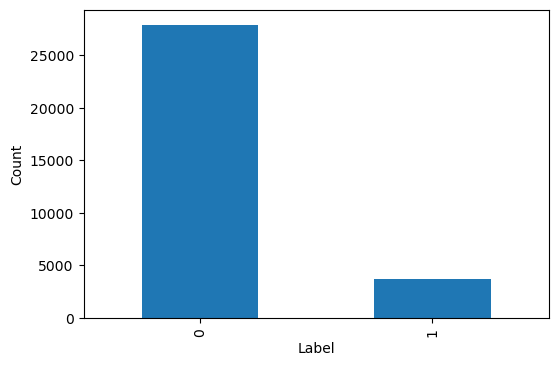

In [250]:
# train데이터의 y값의 분포(BAR PLOT)
plt.figure(figsize=(6,4))
df_trn['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

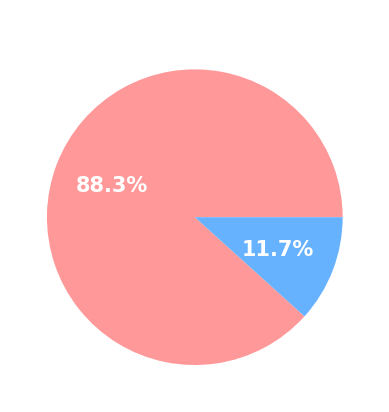

In [252]:
# train데이터의 y값의 분포(PIE CHART)

# 파이 차트 색상 설정
colors = ['#FF9999', '#66B2FF', '#FFCC66', '#99FF99', '#CC99FF']  # 밝고 대비가 잘 되는 색상

# 파이 차트 그리기
df_trn['label'].value_counts().plot(
    kind='pie',
    colors=colors,
    autopct='%1.1f%%',  # 비율 표시
    textprops={'color': 'white', 'fontsize': 15, 'fontweight': 'bold'}  # 텍스트를 흰색으로 설정하고 폰트 크기 조정
)

# 제목 및 기타 설정
plt.title('Distribution of Labels', color='white', fontsize=14)  # 제목 흰색, 폰트 크기 조정
plt.gca().set_facecolor('#2E2E2E')  # 차트 내부 배경색 설정
plt.ylabel('')  # y축 라벨 제거
plt.xlabel('')  # x축 라벨 제거
plt.show()

#### 1.3 EDA

In [255]:
#수치형 변수열 선택
numeric_columns = df_trn.select_dtypes(include='number')

#'label'열과 나머지 수치형 변수들과의 상관계수 계산
correlation_with_label = numeric_columns.corr()['label'].sort_values(ascending=False)

# 표시
correlation_with_label

label       1.000000
duration    0.391085
pdays       0.097961
previous    0.086401
balance     0.051078
age         0.034886
day        -0.026003
campaign   -0.074137
Name: label, dtype: float64

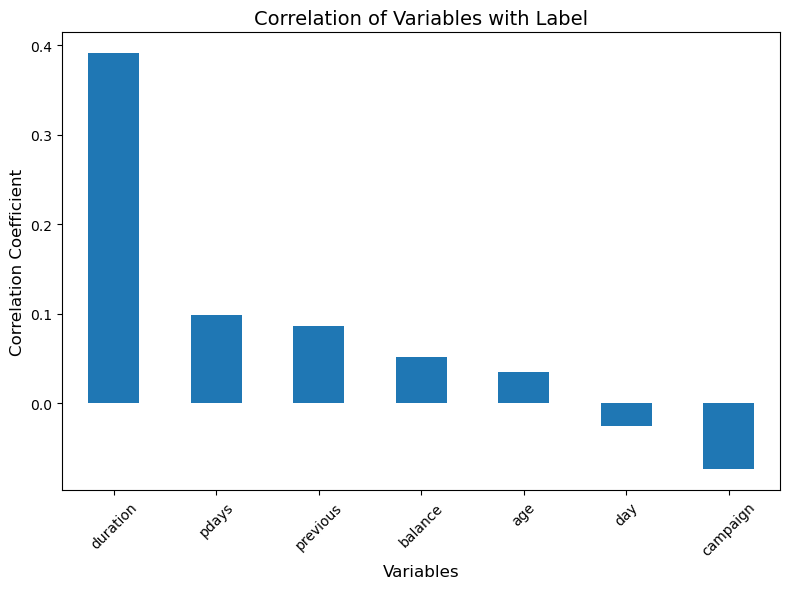

In [257]:
#그래프로 시각화
plt.figure(figsize=(8, 6))
correlation_with_label.drop('label').plot(kind='bar')

plt.title('Correlation of Variables with Label', fontsize=14)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

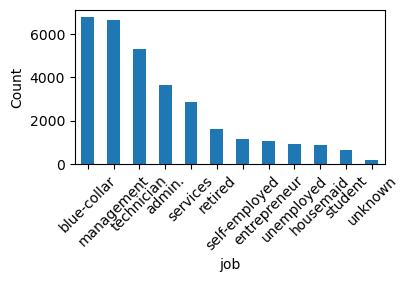

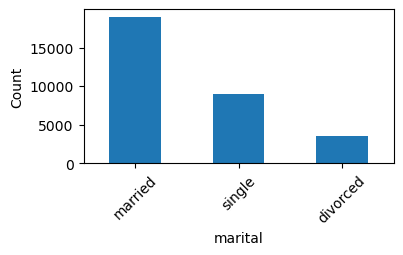

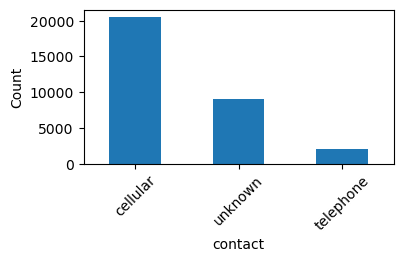

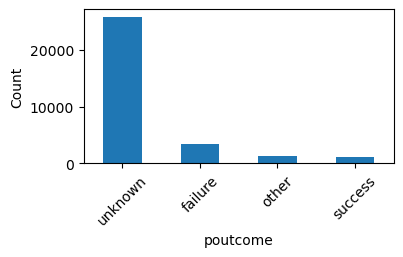

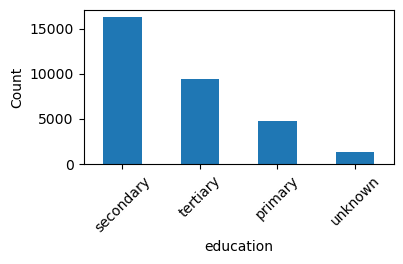

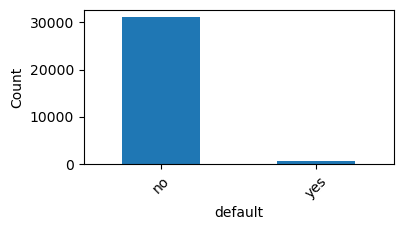

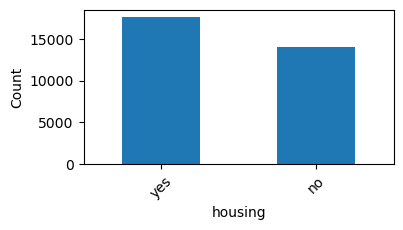

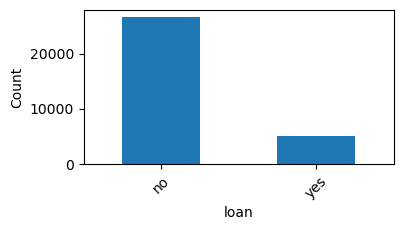

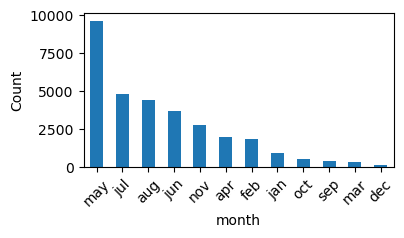

In [259]:
# 범주형 변수의 분포
cat = ['job','marital','contact','poutcome','education','default','housing','loan','month']
for col in cat:
    value_counts = df_trn[col].value_counts()
    value_counts.plot(kind='bar', figsize=(4, 2))
    plt.xticks(rotation=45, ha='center')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

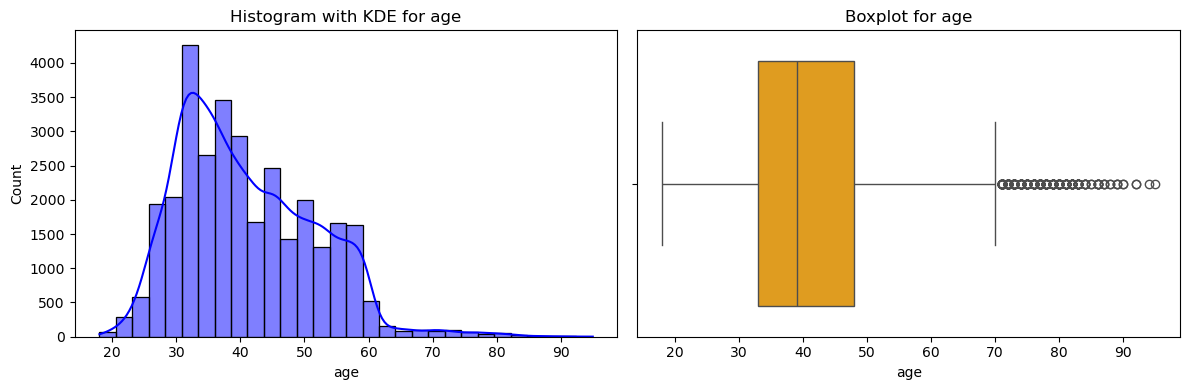

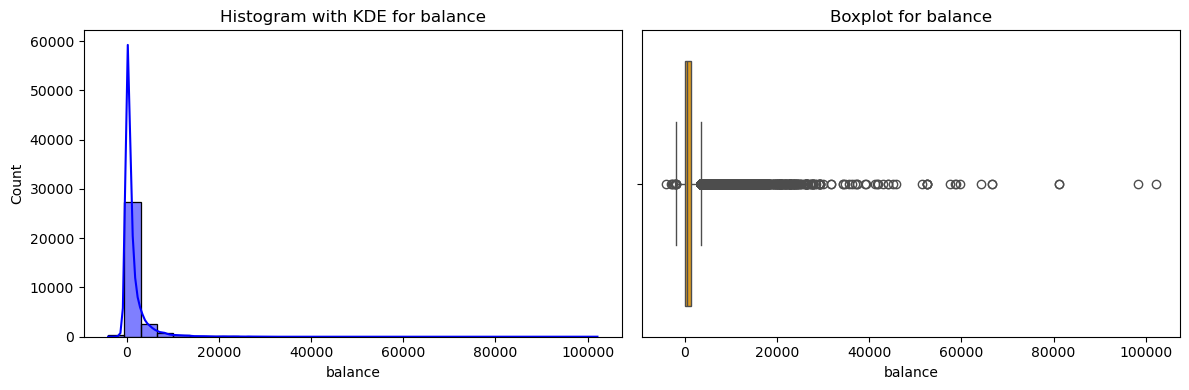

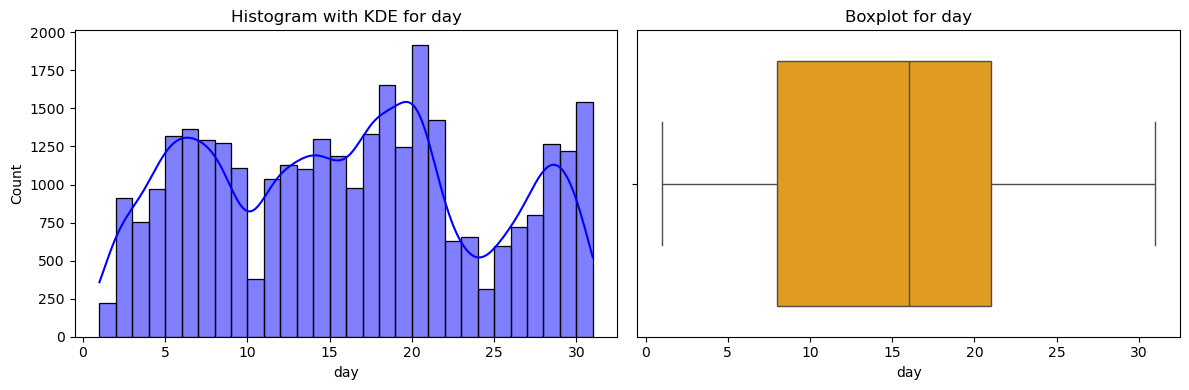

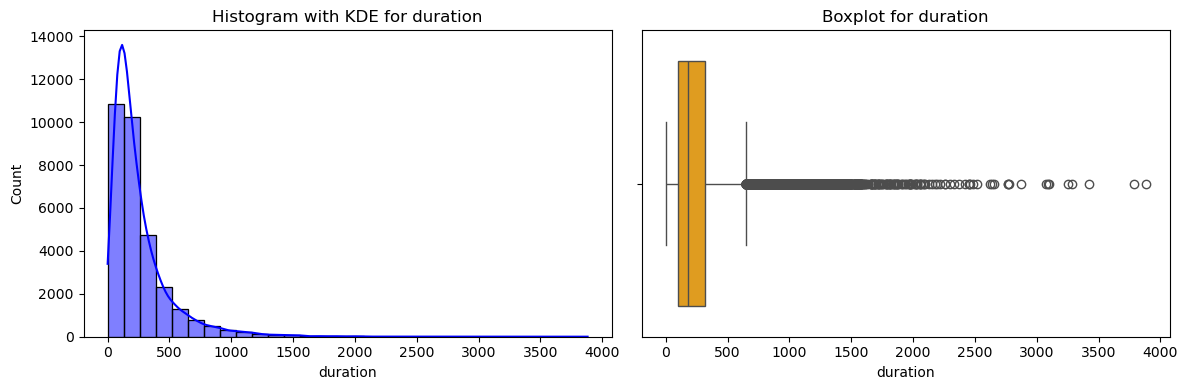

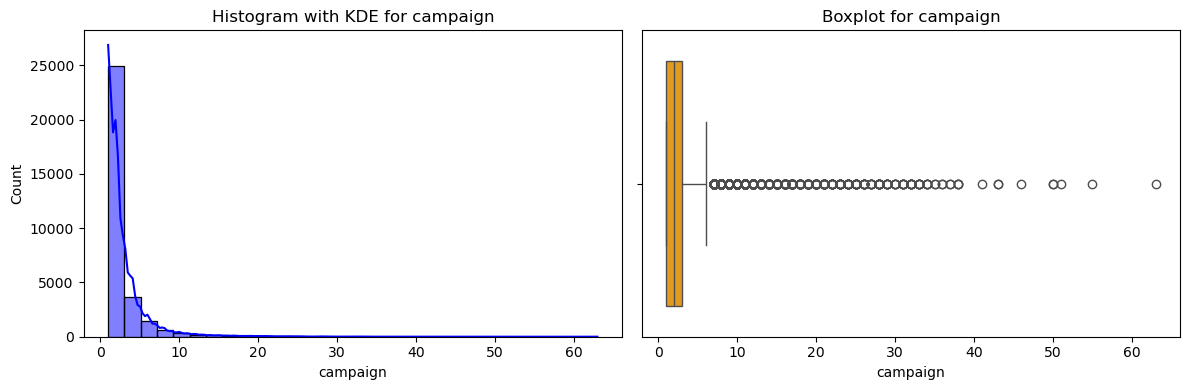

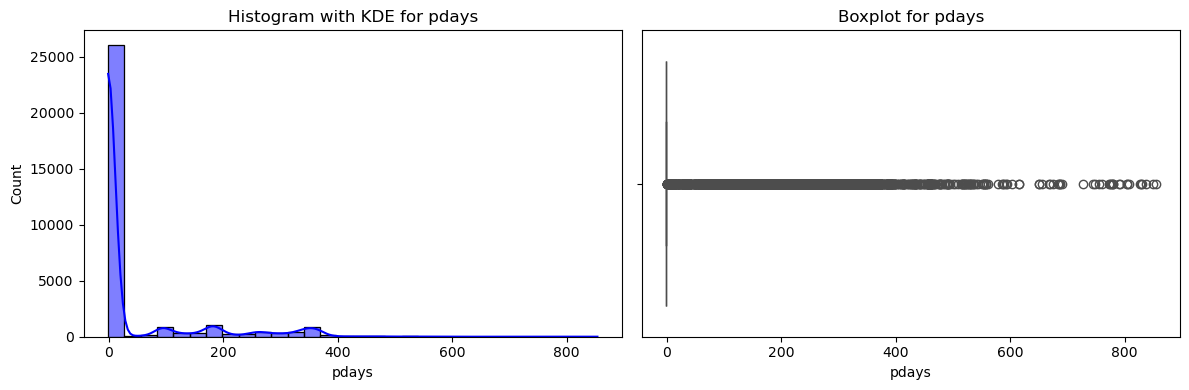

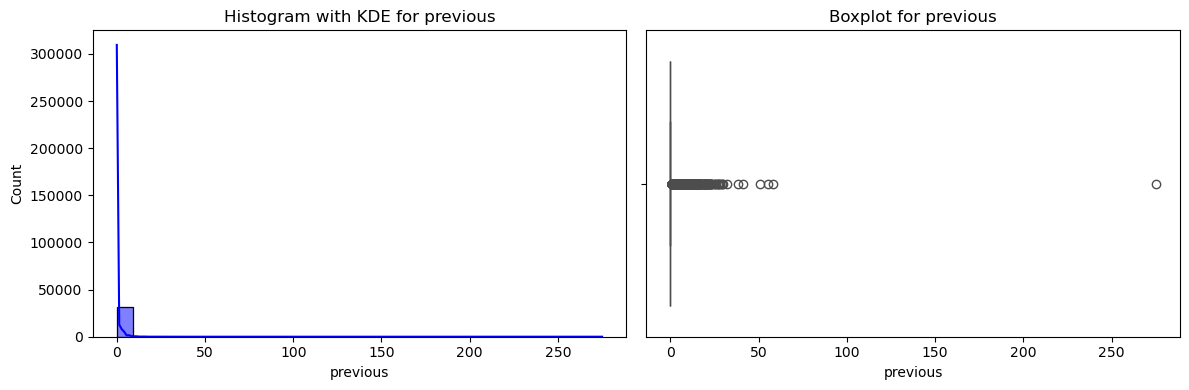

In [260]:
# 수치형 변수의 분포와 Boxplot
num = ['age','balance','day','duration','campaign','pdays','previous']
for col in num:
    plt.figure(figsize=(12, 4))
    
    # 1. 히스토그램 + 분포선
    plt.subplot(1, 2, 1)
    sns.histplot(df_trn[col], kde=True, bins=30, color='blue', edgecolor='black')
    plt.title(f'Histogram with KDE for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    
    # 2. 박스플롯
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_trn[col], color='orange')
    plt.title(f'Boxplot for {col}')
    plt.xlabel(col)
    
    # 그래프 보여주기
    plt.tight_layout()
    plt.show()

### 2. 데이터 전처리

#### 2.1 범주형 데이터 인코딩

In [263]:
# 범주형 데이터를 라벨 인코딩
cat = ['job','marital','contact','poutcome','education','default','housing','loan','month']
label_encoder = {}
for col in cat:
    le = LabelEncoder()
    df_trn[col] = le.fit_transform(df_trn[col])
    df_tst[col] = le.transform(df_tst[col])
    label_encoder[col] = le

#### 2.2 파생 변수 생성

In [266]:
# 계절을 반환하는 함수 정의
def get_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'

In [267]:
# 데이터 전처리 함수 정의
def preprocess_data(df_trn, df_tst):

    le = LabelEncoder()
    
    # pdays 를 갖고 연락여부로 이진분류한 새로운 칼럼 생성
    df_trn['pdays_contacted'] = (df_trn['pdays'] != -1).astype(int)
    df_tst['pdays_contacted'] = (df_tst['pdays'] != -1).astype(int)
    
    # 흠....
    df_trn['duration_per_campaign'] = df_trn['duration'] / (df_trn['campaign'] + 1)
    df_tst['duration_per_campaign'] = df_tst['duration'] / (df_tst['campaign'] + 1)
    
    # day와 month를 통합하여 연속적인 시간 정보를 제공하기 위한 새로운 칼럼 생성
    df_trn['day_of_year'] = df_trn['day'] + (df_trn['month'] - 1) * 30
    df_tst['day_of_year'] = df_tst['day'] + (df_tst['month'] - 1) * 30
    
    # 계별 특성을 학습할 수 있도록 새로운 칼럼 생성
    df_trn['season'] = df_trn['month'].apply(get_season)
    df_tst['season'] = df_tst['month'].apply(get_season)
    # 범주형인 season을 라벨인코딩 수행
    df_trn['season'] = le.fit_transform(df_trn['season'])
    df_tst['season'] = le.transform(df_tst['season'])
    
    return df_trn, df_tst

In [268]:
# 전처리 함수 적용 후 할당
df_trn_preprocessed, df_tst_preprocessed = preprocess_data(df_trn,df_tst)

#### 2.3 Feature와 Target 분리

In [270]:
total_cols = [x for x in df_trn.columns]

id_cols = ['ID']
y_cols = ['label']
x_cols = [x for x in total_cols if x not in id_cols+y_cols]

In [271]:
# feature와 target분리
df_trn_x = df_trn_preprocessed[x_cols]
df_trn_y = df_trn_preprocessed[y_cols].values.ravel()
df_tst_x = df_tst_preprocessed[x_cols]

In [272]:
df_trn_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    31647 non-null  int64  
 1   job                    31647 non-null  int32  
 2   marital                31647 non-null  int32  
 3   education              31647 non-null  int32  
 4   default                31647 non-null  int32  
 5   balance                31647 non-null  int64  
 6   housing                31647 non-null  int32  
 7   loan                   31647 non-null  int32  
 8   contact                31647 non-null  int32  
 9   day                    31647 non-null  int64  
 10  month                  31647 non-null  int32  
 11  duration               31647 non-null  int64  
 12  campaign               31647 non-null  int64  
 13  pdays                  31647 non-null  int64  
 14  previous               31647 non-null  int64  
 15  po

### 3. 모델 정의 및 학습

#### 3.1 검증 데이터 분리

In [275]:
# 검증 데이터셋 분리
df_retrn_x, df_val_x, df_retrn_y, df_val_y = train_test_split(df_trn_x, df_trn_y, test_size=0.2, random_state=42, stratify=df_trn_y)

#### 3.2 초기 모델 정의 및 학습

In [277]:
# 초기 모델 정의
base_model = lgbm.LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced')
#학습
base_model.fit(df_retrn_x, df_retrn_y)

LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)

#### 3.3 변수 중요도 분석

In [279]:
# Feature Importance 추출
importances = base_model.feature_importances_
features = df_retrn_x.columns

# 중요도를 데이터프레임으로 저장
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 출력
print(importance_df)

                  Feature  Importance
18            day_of_year         588
11               duration         429
5                 balance         275
0                     age         273
17  duration_per_campaign         271
9                     day         214
13                  pdays         184
1                     job         126
8                 contact          93
10                  month          92
12               campaign          74
15               poutcome          71
3               education          67
6                 housing          63
14               previous          54
19                 season          48
2                 marital          41
7                    loan          28
4                 default           9
16        pdays_contacted           0


#### 3.4 변수 선택법

In [281]:
# 변수 선택 모델 정의
sfs = SequentialFeatureSelector(
    base_model,
    n_features_to_select='auto',
    direction='forward',
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# 변수 선택 모델 학습하기
sfs.fit(df_retrn_x, df_retrn_y)

SequentialFeatureSelector(estimator=LGBMClassifier(class_weight='balanced',
                                                   random_state=42,
                                                   verbose=-1),
                          n_jobs=-1, scoring='f1')

In [282]:
# 선택된 변수 할당하기
selected_features = df_retrn_x.columns[sfs.get_support()].tolist()
print(f"선택된 변수: {selected_features}")

선택된 변수: ['age', 'housing', 'contact', 'day', 'duration', 'campaign', 'pdays', 'poutcome', 'duration_per_campaign', 'day_of_year']


In [283]:
# 선택된 변수로 데이터 재구성
df_retrn_x_selected = df_retrn_x[selected_features]
df_val_x_selected = df_val_x[selected_features]
df_tst_x_selected = df_tst_x[selected_features]

### 4. 모델 최적화

#### 4.1 하이퍼파라미터 튜닝

In [286]:
# 파라미터 리스트 설정
param_random = {
    'learning_rate': [0.1,0.15,0.2],
    'n_estimators': [300,400,500],
    'max_depth': [3,4,5],
    'min_child_samples': [50, 100, 150],
    'subsample': [0.7,0.8,0.9],
    'colsample_bytree': [0.6,0.7,0.8],
    'class_weight': ['balanced']
}

In [287]:
# RandomizedSearchCV 정의 및 학습
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_random,
    n_iter=50,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)
random_search.fit(df_retrn_x_selected, df_retrn_y)
best_model = random_search.best_estimator_
print(f"최적 하이퍼파라미터: {random_search.best_params_}")

최적 하이퍼파라미터: {'subsample': 0.8, 'n_estimators': 400, 'min_child_samples': 100, 'max_depth': 5, 'learning_rate': 0.15, 'colsample_bytree': 0.6, 'class_weight': 'balanced'}


In [288]:
best_model = lgbm.LGBMClassifier(random_state=42,
                                 verbose=-1,
                                 class_weight='balanced',
                                 subsample=0.8,
                                 n_estimators=300,
                                 max_depth=5,
                                 learning_rate=0.2,
                                 colsample_bytree=0.7,
                                 min_child_samples=100)
best_model.fit(df_retrn_x_selected, df_retrn_y)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, learning_rate=0.2,
               max_depth=5, min_child_samples=100, n_estimators=300,
               random_state=42, subsample=0.8, verbose=-1)

#### 4.2 최적의 threshold 찾기

In [290]:
# 예측 확률값
y_prob = best_model.predict_proba(df_val_x_selected)[:, 1]  # 양성 클래스 확률

# Precision, Recall, Threshold 계산
precisions, recalls, thresholds = precision_recall_curve(df_val_y, y_prob)

# F1 Score 계산
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

# 최적 Threshold 선택
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold for F1 Score: {best_threshold}")

# 최적 Threshold 기반 예측
y_pred = (y_prob >= best_threshold).astype(int)

# F1 Score 확인
print(f"Optimized F1 Score: {f1_score(df_val_y, y_pred)}")


Best Threshold for F1 Score: 0.6194620606052237
Optimized F1 Score: 0.6228632478632479


### 5. 모델 평가

In [292]:
# threshold 설정
thres=0.619

In [294]:
# 훈련 데이터에 대한 성능 평가
y_retrn_pred_proba = best_model.predict_proba(df_retrn_x_selected)[:, 1]
y_retrn_pred_label = (y_retrn_pred_proba > thres).astype(int)

print(f"훈련 데이터 Accuracy: {accuracy_score(df_retrn_y, y_retrn_pred_label)}")
print(f"훈련 데이터 Precision: {precision_score(df_retrn_y, y_retrn_pred_label)}")
print(f"훈련 데이터 Recall: {recall_score(df_retrn_y, y_retrn_pred_label)}")
print(f"훈련 데이터 F1 Score: {f1_score(df_retrn_y, y_retrn_pred_label)}")

훈련 데이터 Accuracy: 0.9218706797803847
훈련 데이터 Precision: 0.6081794195250659
훈련 데이터 Recall: 0.9338284942606347
훈련 데이터 F1 Score: 0.7366178428761652


검증 데이터로 성능 평가

In [303]:
# 검증 데이터에 대한 성능 평가
y_val_pred_proba = best_model.predict_proba(df_val_x_selected)[:, 1]
y_val_pred_label = (y_val_pred_proba > thres).astype(int)

print(f"검증 데이터 Accuracy: {accuracy_score(df_val_y, y_val_pred_label)}")
print(f"검증 데이터 Precision: {precision_score(df_val_y, y_val_pred_label)}")
print(f"검증 데이터 Recall: {recall_score(df_val_y, y_val_pred_label)}")
print(f"검증 데이터 F1 Score: {f1_score(df_val_y, y_val_pred_label)}")

검증 데이터 Accuracy: 0.8881516587677725
검증 데이터 Precision: 0.5141093474426808
검증 데이터 Recall: 0.7878378378378378
검증 데이터 F1 Score: 0.6221985058697972


### 6. 최종 모델 학습(전체 훈련 데이터)

In [306]:
df_trn_x_selected = df_trn_x[selected_features]
best_model.fit(df_trn_x_selected, df_trn_y)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, learning_rate=0.2,
               max_depth=5, min_child_samples=100, n_estimators=300,
               random_state=42, subsample=0.8, verbose=-1)

### 7. 테스트 데이터에 대한 예측 후 저장하기

#### 7.1 테스트데이터에 대한 예측 수행

In [311]:
y_tst_pred_proba = best_model.predict_proba(df_tst_x_selected)[:,1]

In [312]:
y_tst_pred_label = (y_tst_pred_proba > thres).astype(int)

#### 7.2 예측결과 저장하기

In [314]:
df_submission = pd.read_csv('submission_example.csv')

In [315]:
df_submission.head()

,ID,label
0,test00001,0
1,test00002,0
2,test00003,0
3,test00004,0
4,test00005,0


In [316]:
df_submission['label'] = y_tst_pred_label

In [317]:
df_submission['label'].value_counts()

label
0    11180
1     2384
Name: count, dtype: int64

In [318]:
# 다하고 눌러라!!!!
#filename = 'LightGBM_Yeon_final.csv'
#df_submission.to_csv(filename, index=False)